In [1]:
import pandas
from numpy import round_
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import utils
import graphviz
import relabeling_pydl

In [2]:
df = pandas.read_csv("../dataset_perso/Lawsuit.csv")
FILE_NAME = "lawsuit_k_supp2_relab"

del df['ID']
salary_mean = np.mean(np.array(df["Sal94"].tolist(), float))
for i in range(0,len(df)):
    if df.at[i, "Sal94"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Sal94"]
del df["Sal95"]
col = ['Rank', 'Dept']
df = df.drop(['Prate', 'Exper'], axis=1)
df = pd.get_dummies(df, columns=col)

for i in range(0,len(df)):
    if df.at[i, "Gender"] == 1:
        df.at[i, "Gender"] = 0
    else:
        df.at[i, "Gender"] = 1


X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['Gender']
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

In [3]:
result = pandas.read_csv("save/lawsuit_k_supp2.csv")
#result

In [4]:

for leaf_limit in range (1, 4):
    result['accuracy_relab_'+str(leaf_limit)] = np.nan
    result['discrimination_relab_'+str(leaf_limit)] = np.nan
    result['discrimination_relab_abs_'+str(leaf_limit)] = np.nan
    result['accuracy_relab_test_'+str(leaf_limit)] = np.nan
    result['discrimination_relab_test_'+str(leaf_limit)] = np.nan
    result['discrimination_relab_test_abs_'+str(leaf_limit)] = np.nan

for threshold in [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
    result['accuracy_relab_'+str(threshold)] = np.nan
    result['discrimination_relab_'+str(threshold)] = np.nan
    result['discrimination_relab_abs_'+str(threshold)] = np.nan
    result['accuracy_relab_test_'+str(threshold)] = np.nan
    result['discrimination_relab_test_'+str(threshold)] = np.nan
    result['discrimination_relab_test_abs_'+str(threshold)] = np.nan

In [5]:
import math
import ast
from tqdm import tqdm
def round_down(a):
    return math.floor(a * 100000)/100000.0
clf = DL85Classifier(max_depth=1, error_function=lambda tids: utils.misclassified(list(tids), y_train), min_sup=2, time_limit=600)
clf.fit(X_train)

run = True
if run:
    for leaf_limit in range (1, 4):
        for index, row in tqdm(result.iterrows(), total=result.shape[0]):
            #if (index in [1551, 1573, 1591, 1595, 1596, 1597] or index < 1900) and False:
            #    continue
            random_state = result.at[index, 'random_state']
            accuracy_train = result.at[index, 'accuracy_pred']
            discrimination_train_pred = result.at[index, 'discrimination_train_pred']

            X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)
            clf.tree_ = ast.literal_eval(result.at[index, 'clf.tree_'])
            y_pred_train = clf.predict(X_train)

            leafs_relab = relabeling_pydl.relab_leaf_limit(clf.tree_, y_train, y_pred_train, sensitive_train, leaf_limit)
            sum_acc = 0
            sum_disc = 0
            for leaf in leafs_relab:
                relabeling_pydl.browse_and_relab(clf.tree_, list(leaf.path), leaf)
                sum_acc += leaf.acc
                sum_disc += leaf.disc

            y_pred_train_relab = clf.predict(X_train)
            discrimation_train_pred_relab = round_down(relabeling_pydl.discrimination(y_train, y_pred_train_relab, sensitive_train))
            accuracy_train_relab = round_down(accuracy_score(y_train, y_pred_train_relab))
            result.at[index, 'accuracy_relab_'+str(leaf_limit)] = accuracy_train_relab
            utils.tree_upgrade(clf.tree_, y_train, y_pred_train_relab, sensitive_train)
            sum_discri_ = round_down(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False))
            sum_discri_abs_ = round_down(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True))
            result.at[index, 'discrimination_relab_'+str(leaf_limit)] = sum_discri_
            result.at[index, 'discrimination_relab_abs_'+str(leaf_limit)] = sum_discri_abs_

            y_pred_test_relab = clf.predict(X_test)
            discri_test= list()
            utils.get_discri_test(clf.tree_, X_test, y_pred_test_relab, sensitive_test, discri_test, X.columns, path=None)
            sum_discrimination_additive_test_pred = sum(discri_test)
            sum_discrimination_additive_test_pred_abs = 0
            [sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]

            result.at[index, 'accuracy_relab_test_'+str(leaf_limit)] = round_down(accuracy_score(y_test, y_pred_test_relab))
            result.at[index, 'discrimination_relab_test_'+str(leaf_limit)] = sum_discrimination_additive_test_pred
            result.at[index, 'discrimination_relab_test_abs_'+str(leaf_limit)] = sum_discrimination_additive_test_pred_abs


            new_acc= round_down(accuracy_train+sum_acc)
            new_disc = round_down(discrimination_train_pred+sum_disc)
            if not (round_down(new_acc) == round_down(accuracy_train_relab) or round_down(new_disc)== round_down(discrimation_train_pred_relab)):
                print(index)
                print(result.iloc[index])
                print(f"{relabeling_pydl.discrimination(y_train, y_pred_train_relab, sensitive_train)}")
                print()

                for leaf in leafs_relab:
                    print(leaf)
                print(f"Accuracy:\n"
                      f"    Before      : {accuracy_train}\n"
                      f"    Leafs       : {sum_acc}\n"
                      f"    After       : {accuracy_train_relab}\n"
                      f"    Before+Leafs: {new_acc}\n"
                      f"    Check       : {round_down(new_acc) == round_down(accuracy_train_relab)}\n"
                      f"    Real diff   : {accuracy_train - accuracy_train_relab}")
                print(f"Discrim:\n"
                      f"    Before      : {discrimination_train_pred}\n"
                      f"    Leafs       : {sum_disc }\n"
                      f"    After       : {discrimation_train_pred_relab}\n"
                      f"    Before+Leafs: {new_disc}\n"
                      f"    Check       : {round_down(new_disc)== round_down(discrimation_train_pred_relab)}\n"
                      f"    Real diff   : {discrimination_train_pred - discrimation_train_pred_relab}")
                display(graphviz.Source(utils.export_graphviz(clf)))

                assert(round_down(new_acc) == round_down(accuracy_train_relab))
                assert(round_down(new_disc)== round_down(discrimation_train_pred_relab))
        result.to_csv('save/'+FILE_NAME+'.csv', index=False)

100%|██████████| 3465/3465 [02:31<00:00, 22.85it/s]


In [6]:
if run:
    for threshold in [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
        for index, row in tqdm(result.iterrows(), total=result.shape[0]):

            random_state = result.at[index, 'random_state']
            accuracy_train = result.at[index, 'accuracy_pred']
            discrimination_train_pred = result.at[index, 'discrimination_train_pred']

            X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)
            clf.tree_ = ast.literal_eval(result.at[index, 'clf.tree_'])
            y_pred_train = clf.predict(X_train)

            leafs_relab = relabeling_pydl.relab(clf.tree_, y_train, y_pred_train, sensitive_train, threshold)
            sum_acc = 0
            sum_disc = 0
            for leaf in leafs_relab:
                relabeling_pydl.browse_and_relab(clf.tree_, list(leaf.path), leaf)
                sum_acc += leaf.acc
                sum_disc += leaf.disc

            y_pred_train_relab = clf.predict(X_train)
            discrimation_train_pred_relab = round_down(relabeling_pydl.discrimination(y_train, y_pred_train_relab, sensitive_train))
            accuracy_train_relab = round_down(accuracy_score(y_train, y_pred_train_relab))
            result.at[index, 'accuracy_relab_'+str(threshold)] = accuracy_train_relab
            utils.tree_upgrade(clf.tree_, y_train, y_pred_train_relab, sensitive_train)
            sum_discri_ = round_down(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False))
            sum_discri_abs_ = round_down(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True))
            result.at[index, 'discrimination_relab_'+str(threshold)] = sum_discri_
            result.at[index, 'discrimination_relab_abs_'+str(threshold)] = sum_discri_abs_

            y_pred_test_relab = clf.predict(X_test)
            discri_test= list()
            utils.get_discri_test(clf.tree_, X_test, y_pred_test_relab, sensitive_test, discri_test, X.columns, path=None)
            sum_discrimination_additive_test_pred = sum(discri_test)
            sum_discrimination_additive_test_pred_abs = 0
            [sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]

            result.at[index, 'accuracy_relab_test_'+str(threshold)] = round_down(accuracy_score(y_test, y_pred_test_relab))
            result.at[index, 'discrimination_relab_test_'+str(threshold)] = sum_discrimination_additive_test_pred
            result.at[index, 'discrimination_relab_test_abs_'+str(threshold)] = sum_discrimination_additive_test_pred_abs

            new_acc= round_down(accuracy_train+sum_acc)
            new_disc = round_down(discrimination_train_pred+sum_disc)
            if not ( discrimation_train_pred_relab <= threshold or round_down(new_acc) == round_down(accuracy_train_relab) or round_down(new_disc)== round_down(discrimation_train_pred_relab)):
                print(index)
                print(result.iloc[index])
                print(f"{discrimation_train_pred_relab}")
                print()

                for leaf in leafs_relab:
                    print(leaf)
                print(f"Accuracy:\n"
                      f"    Before      : {accuracy_train}\n"
                      f"    Leafs       : {sum_acc}\n"
                      f"    After       : {accuracy_train_relab}\n"
                      f"    Before+Leafs: {new_acc}\n"
                      f"    Check       : {round_down(new_acc) == round_down(accuracy_train_relab)}\n"
                      f"    Real diff   : {accuracy_train - accuracy_train_relab}")
                print(f"Discrim:\n"
                      f"    Before      : {discrimination_train_pred}\n"
                      f"    Leafs       : {sum_disc }\n"
                      f"    After       : {discrimation_train_pred_relab}\n"
                      f"    Before+Leafs: {new_disc}\n"
                      f"    Check       : {round_down(new_disc)== round_down(discrimation_train_pred_relab)}\n"
                      f"    Real diff   : {discrimination_train_pred - discrimation_train_pred_relab}")
                display(graphviz.Source(utils.export_graphviz(clf)))
                assert(relabeling_pydl.discrimination(y_train, y_pred_train_relab, sensitive_train) <= threshold)
                assert(round_down(new_acc) == round_down(accuracy_train_relab))
                assert(round_down(new_disc)== round_down(discrimation_train_pred_relab))

        result.to_csv('save/'+FILE_NAME+'.csv', index=False)

100%|██████████| 3465/3465 [02:17<00:00, 25.26it/s]


In [7]:
result = pandas.read_csv('save/'+FILE_NAME+'.csv')
result

,k,depth,random_state,clf.error_,clf.accuracy_,accuracy_pred,accuracy_test,sum_misclassified_train,discrimination_train,sum_discrimination_additive_train,...,discrimination_relab_abs_0.25,accuracy_relab_test_0.25,discrimination_relab_test_0.25,discrimination_relab_test_abs_0.25,accuracy_relab_0.3,discrimination_relab_0.3,discrimination_relab_abs_0.3,accuracy_relab_test_0.3,discrimination_relab_test_0.3,discrimination_relab_test_abs_0.3
0,0,1,1,51.000000,0.755981,0.755981,0.730769,51,0.325619,0.325619,...,0.15647,0.73076,0.266667,0.266667,0.75598,0.15647,0.15647,0.73076,0.266667,0.266667
1,0,1,3,48.000000,0.770335,0.770335,0.673077,48,0.304364,0.304364,...,0.23453,0.67307,-0.046083,0.046083,0.77033,0.23453,0.23453,0.67307,-0.046083,0.046083
2,0,1,5,49.000000,0.765550,0.765550,0.692308,49,0.324563,0.324563,...,0.17956,0.69230,0.172619,0.172619,0.76555,0.17956,0.17956,0.69230,0.172619,0.172619
3,0,1,7,51.000000,0.755981,0.755981,0.730769,51,0.290782,0.290782,...,0.18579,0.73076,0.137931,0.137931,0.75598,0.18579,0.18579,0.73076,0.137931,0.137931
4,0,1,9,54.000000,0.741627,0.741627,0.788462,54,0.316116,0.316116,...,0.14462,0.78846,0.297386,0.297386,0.74162,0.14462,0.14462,0.78846,0.297386,0.297386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3460,100000,7,89,31923.021484,-151.741730,0.885167,0.903846,24,0.318990,0.318990,...,0.24230,0.88461,0.194903,0.299850,0.88516,0.28198,0.28198,0.90384,0.151424,0.343328
3461,100000,7,93,29877.371094,-141.953934,0.894737,0.923077,22,0.298554,0.298554,...,0.23760,0.92307,0.421569,0.421569,0.89473,0.22727,0.23760,0.92307,0.421569,0.421569
3462,100000,7,95,35396.804688,-168.362701,0.909091,0.846154,19,0.353778,0.353778,...,0.24872,0.84615,0.161085,0.263158,0.90909,0.27331,0.27331,0.84615,0.161085,0.263158
3463,100000,7,97,34281.562500,-163.026611,0.913876,0.807692,18,0.342636,0.342636,...,0.24263,0.80769,0.269231,0.269231,0.91387,0.24263,0.24263,0.80769,0.269231,0.269231


In [8]:
_COLORS11 = ['#8b4513', '#006400', '#4682b4', '#4b0082', '#ff0000', '#00ff7f', '#00ffff', '#0000ff', '#ffff54',
             '#ff1493', '#ffe4c4']
_COLORS4 = ['#ff0000', '#00ff00', '#0000ff', '#87cefa']
_COLORS5 = ['#008080', '#ffa500', '#00ff00', '#0000ff', '#ff1493']
_COLORS7 = ['#2e8b57', '#ff0000', '#ffd700', '#c71585', '#00ff00', '#0000ff', '#1e90ff']
_COLORS10 = ['#006400', '#00008b', '#b03060', '#ff4500', '#ffd700', '#7cfc00', '#00ffff', '#ff00ff', '#6495ed',
          '#ffdab9']

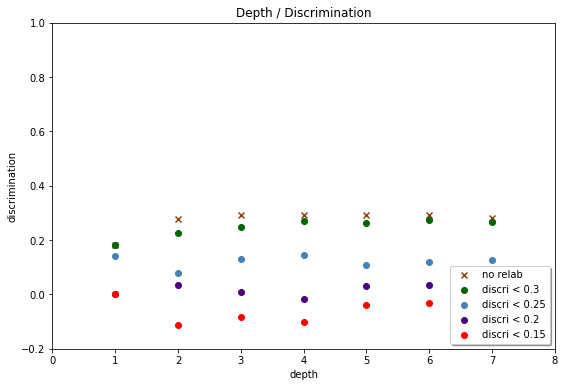

In [9]:
def graphh(axe1, axe2, x_size, y_size):
    colors11 = _COLORS11.copy()
    colors5 = _COLORS11.copy()
    colors4 = _COLORS5.copy()
    legends = ['discri < 0', 'discri < 0.05', 'discri < 0.1', 'discri < 0.15', 'discri < 0.2', 'discri < 0.25','discri < 0.3', 'no relab']
    legends.reverse()
    fig, axes = plt.subplots()
    index_legends = 0
    for x_axe, y_axe in axe1:
        
        y_values_pydl = list()
        x_values_pydl = list()
        isLegend = True
        for depth in result['depth'].unique():
            tmp = result.loc[(result["k"] == 0) & (result["depth"] == depth)]
            y_values_pydl.append(tmp[y_axe].mean())

            if isLegend:
                if index_legends == 0:
                    plt.scatter(depth, tmp[y_axe].mean(), label=legends[index_legends], c=colors5[index_legends], marker='x')
                else:
                    plt.scatter(depth, tmp[y_axe].mean(), label=legends[index_legends], c=colors5[index_legends])
            else:
                if index_legends == 0:
                    plt.scatter(depth, tmp[y_axe].mean(), c=colors5[index_legends], marker='x')
                else:
                    plt.scatter(depth, tmp[y_axe].mean(), c=colors5[index_legends])
            isLegend = False
        index_legends +=1
    #plt.plot(result['depth'].unique(), y_values_pydl, label="Pydl (relab)", c=colors4[1])

        
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth / Discrimination')
    plt.ylabel('discrimination')
    plt.xlabel('depth')
    plt.ylim(y_size[0], y_size[1])
    plt.xlim(x_size[0], x_size[1])
    plt.legend(loc='lower right', shadow=True)

    plt.show()
graphh([('accuracy_pred', 'discrimination_train_pred'), ('accuracy_relab_0.3', 'discrimination_relab_0.3'), ('accuracy_relab_0.2', 'discrimination_relab_0.2'), ('accuracy_relab_0.1', 'discrimination_relab_0.1'), ('accuracy_relab_0.0', 'discrimination_relab_0.0')], ("accuracy_pred", "sum_discrimination_additive_train_pred"), (0, 8), (-0.2, 1))

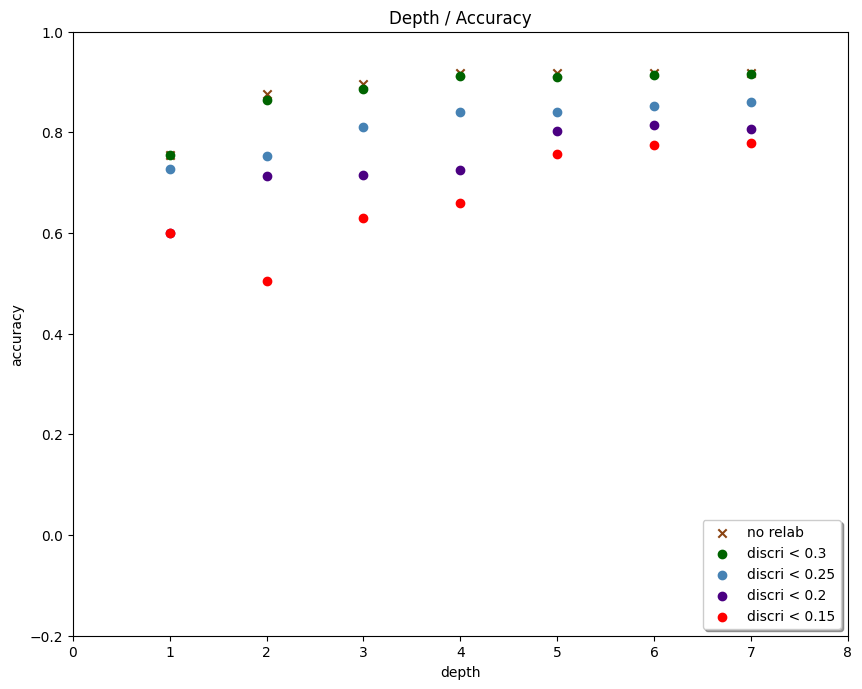

In [10]:
def graphh(axe1, axe2, x_size, y_size):
    colors11 = _COLORS11.copy()
    colors5 = _COLORS11.copy()
    colors4 = _COLORS5.copy()
    legends = ['discri < 0', 'discri < 0.05', 'discri < 0.1', 'discri < 0.15', 'discri < 0.2', 'discri < 0.25','discri < 0.3', 'no relab']
    legends.reverse()
    fig, axes = plt.subplots()
    index_legends = 0
    for x_axe, y_axe in axe1:
        
        y_values_pydl = list()
        x_values_pydl = list()
        isLegend = True
        for depth in result['depth'].unique():
            tmp = result.loc[(result["k"] == 0) & (result["depth"] == depth)]
            y_values_pydl.append(tmp[y_axe].mean())

            if isLegend:
                if index_legends == 0:
                    plt.scatter(depth, tmp[x_axe].mean(), label=legends[index_legends], c=colors5[index_legends], marker='x')
                else:
                    plt.scatter(depth, tmp[x_axe].mean(), label=legends[index_legends], c=colors5[index_legends])
            else:
                if index_legends == 0:
                    plt.scatter(depth, tmp[x_axe].mean(), c=colors5[index_legends], marker='x')
                else:
                    plt.scatter(depth, tmp[x_axe].mean(), c=colors5[index_legends])
            isLegend = False
        index_legends +=1
    #plt.plot(result['depth'].unique(), y_values_pydl, label="Pydl (relab)", c=colors4[1])

        
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth / Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('depth')
    plt.ylim(y_size[0], y_size[1])
    plt.xlim(x_size[0], x_size[1])
    plt.legend(loc='lower right', shadow=True)

    plt.show()
graphh([('accuracy_pred', 'discrimination_train_pred'), ('accuracy_relab_0.3', 'discrimination_relab_0.3'), ('accuracy_relab_0.2', 'discrimination_relab_0.2'), ('accuracy_relab_0.1', 'discrimination_relab_0.1'), ('accuracy_relab_0.0', 'discrimination_relab_0.0')], ("accuracy_pred", "sum_discrimination_additive_train_pred"), (0, 8), (-0.2, 1))

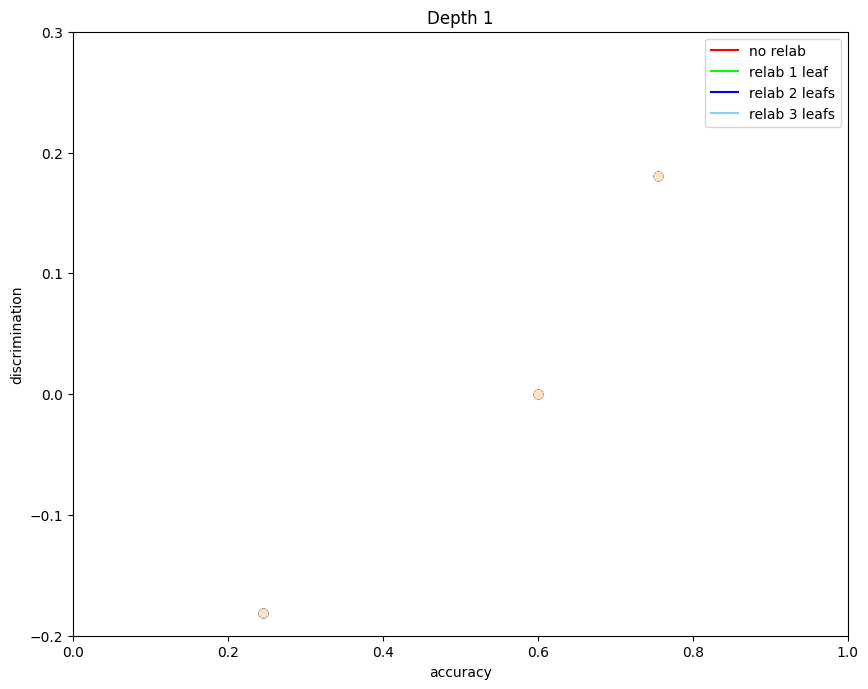

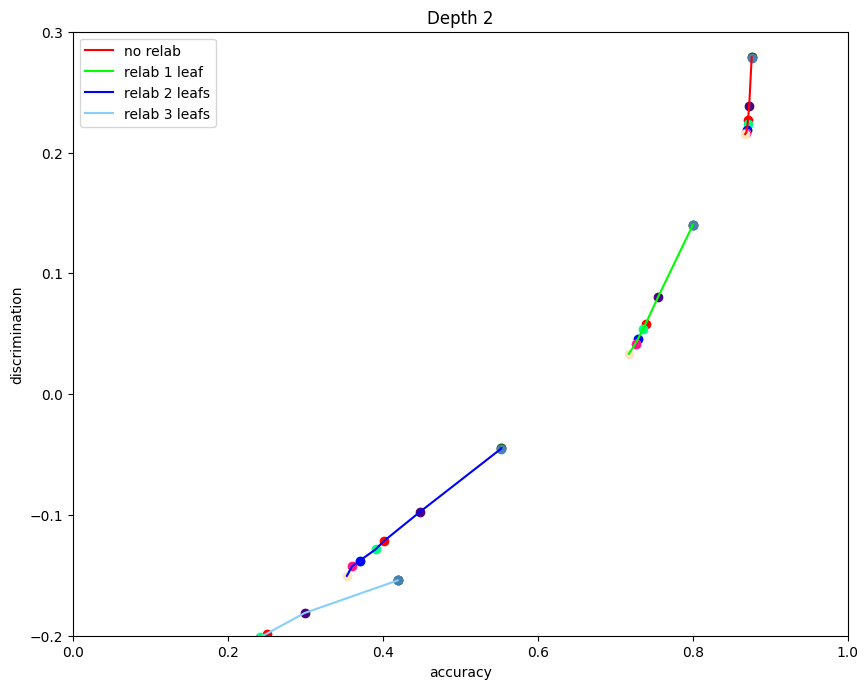

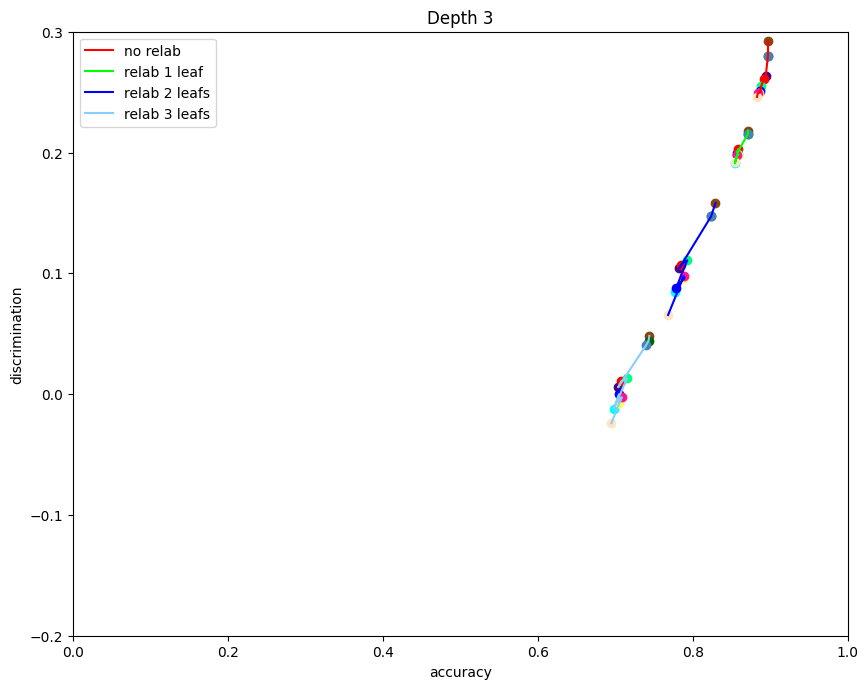

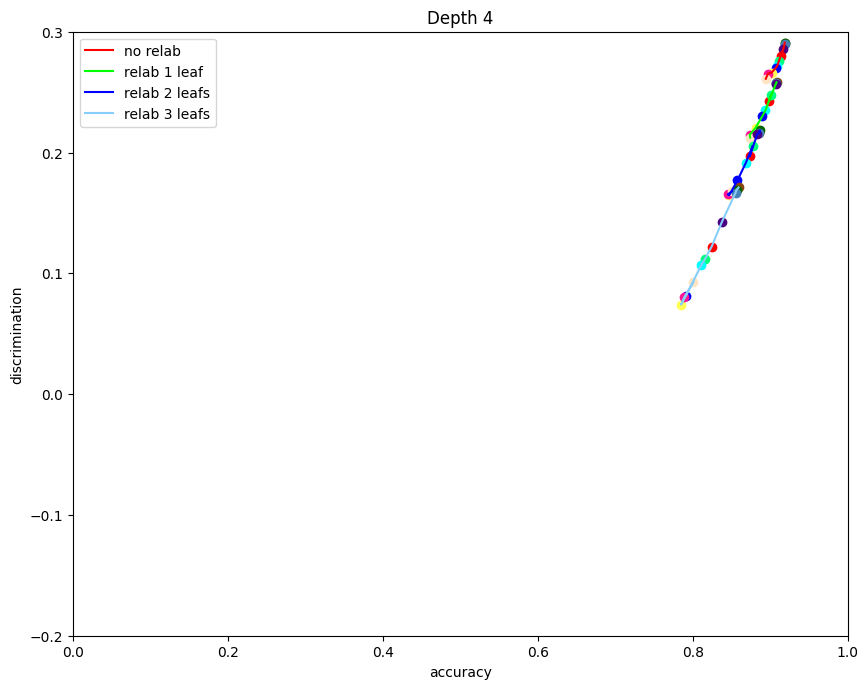

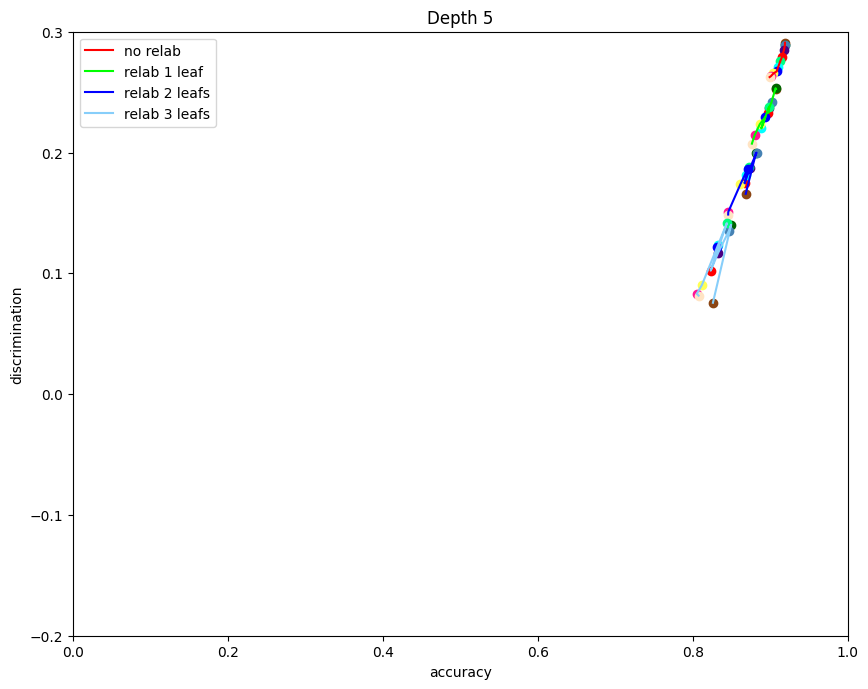

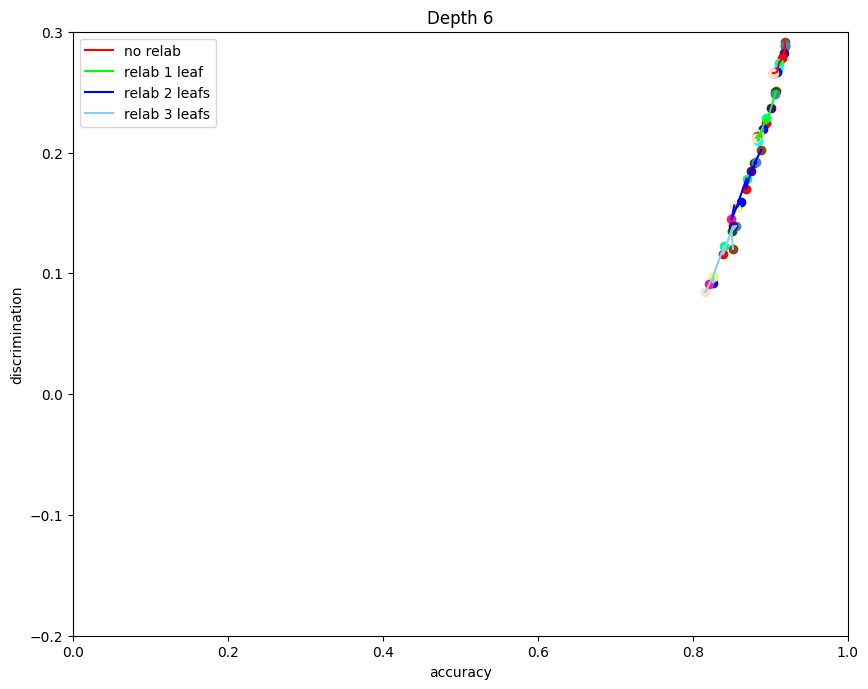

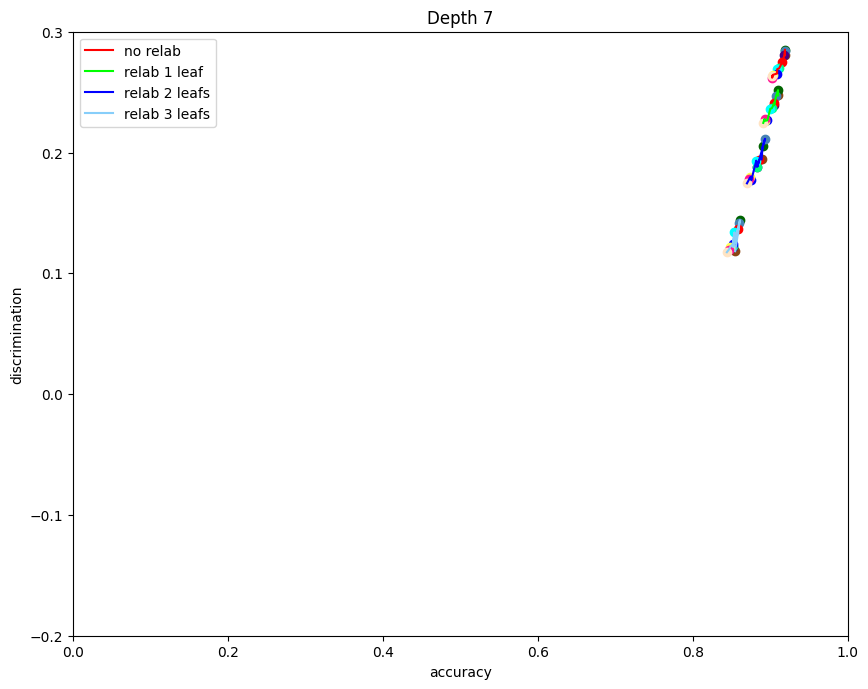

In [11]:
legends = ['no relab', 'relab 1 leaf', 'relab 2 leafs', 'relab 3 leafs']
fig, axes = plt.subplots()
colors11 = _COLORS11.copy()
colors4 = _COLORS4.copy()
for depth in result['depth'].unique():
    index_legends = 0
    for x_axe, y_axe in [('accuracy_pred', 'discrimination_train_pred'), ('accuracy_relab_1', 'discrimination_relab_1'), ('accuracy_relab_2', 'discrimination_relab_2'), ('accuracy_relab_3', 'discrimination_relab_3')]:
        index_color = 0
        y_values = list()
        x_values = list()
        for k in result['k'].unique():
            tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors11[index_color])
            """
            plt.annotate(k, # this is the text
                         (tmp[x_axe].mean(), tmp[y_axe].mean()), # these are the coordinates to position the label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
            """
            index_color +=1

        plt.plot(x_values, y_values, label=legends[index_legends], c=colors4[index_legends])
        index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('discrimination')
    plt.xlabel('accuracy')
    plt.ylim(-0.2, 0.3)
    plt.xlim(0, 1)
    plt.legend()

    plt.show()

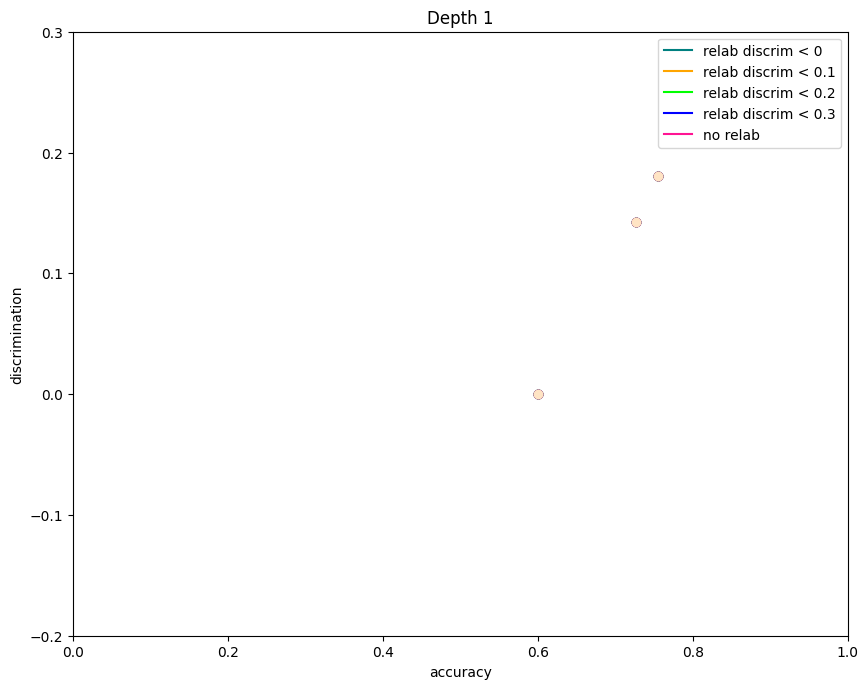

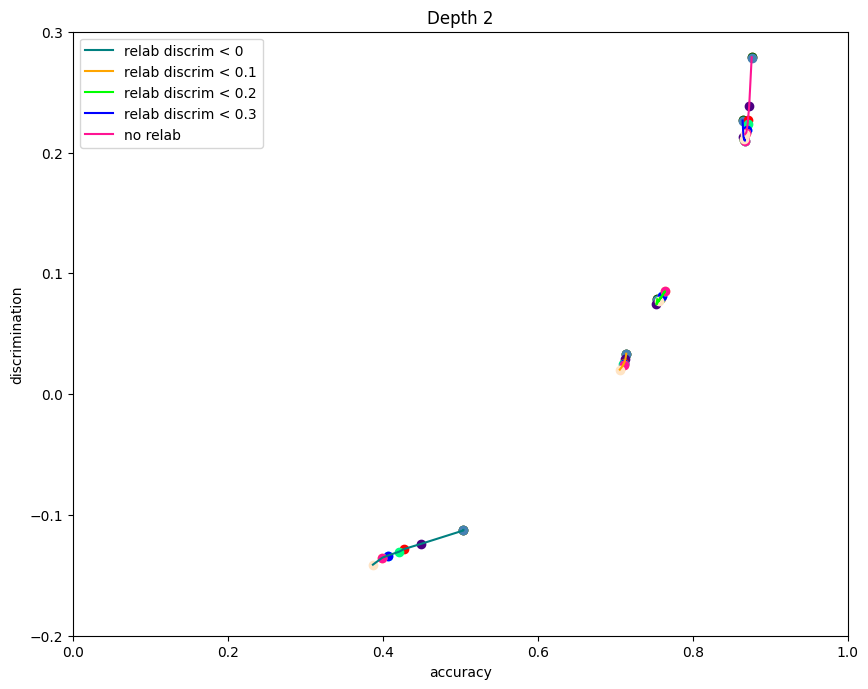

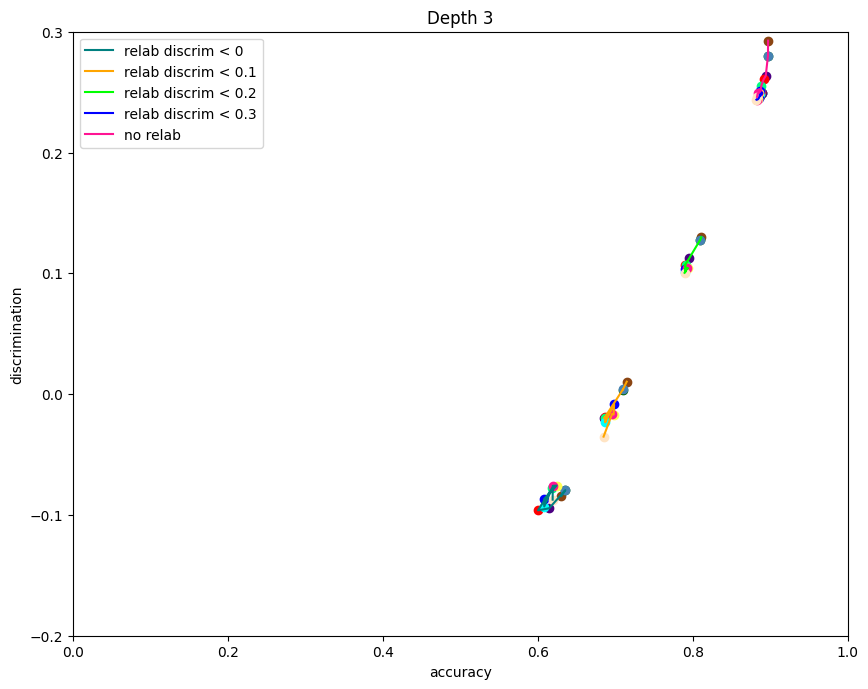

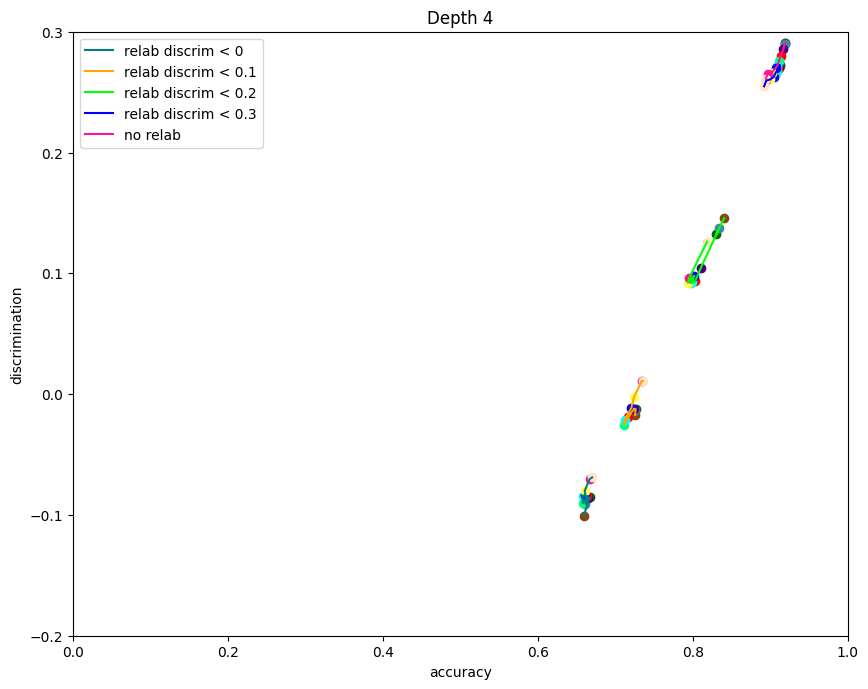

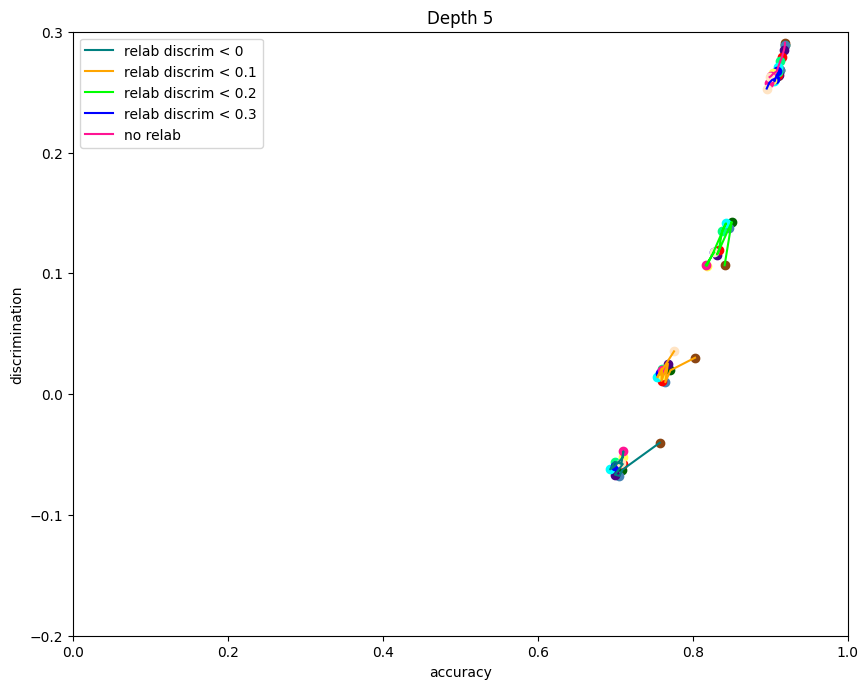

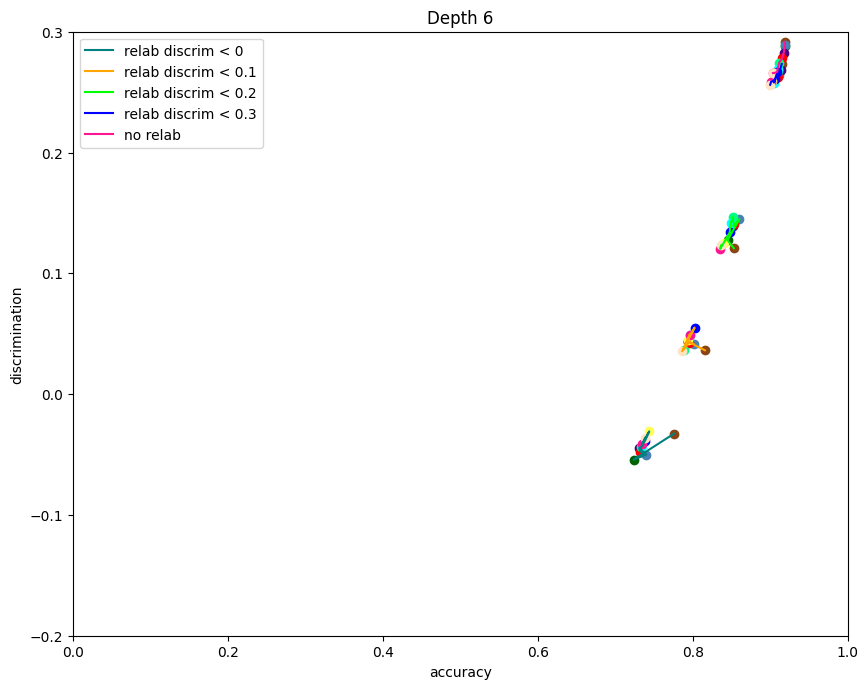

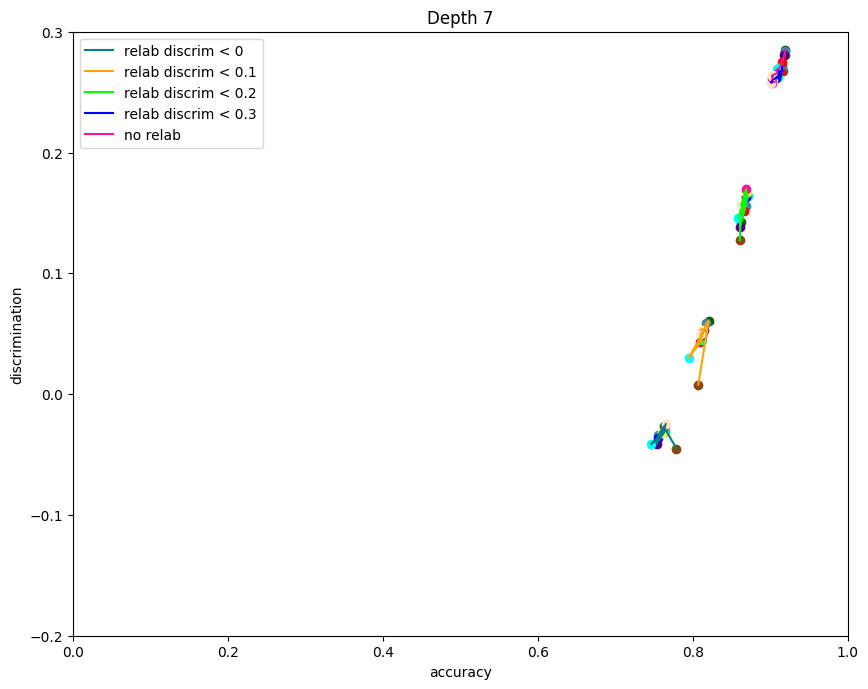

In [12]:
colors11 = _COLORS11.copy()
colors4 = _COLORS5.copy()
legends = ['relab discrim < 0', 'relab discrim < 0.1', 'relab discrim < 0.2', 'relab discrim < 0.3', 'no relab']
fig, axes = plt.subplots()
for depth in result['depth'].unique():
    index_legends = 0
    for x_axe, y_axe in [('accuracy_relab_0.0', 'discrimination_relab_0.0'), ('accuracy_relab_0.1', 'discrimination_relab_0.1'), ('accuracy_relab_0.2', 'discrimination_relab_0.2'), ('accuracy_relab_0.3', 'discrimination_relab_0.3'), ('accuracy_pred', 'discrimination_train_pred')]:
        index_color = 0
        y_values = list()
        x_values = list()
        for k in result['k'].unique():
            tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors11[index_color])
            """
            plt.annotate(k, # this is the text
                         (tmp[x_axe].mean(), tmp[y_axe].mean()), # these are the coordinates to position the label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
            """
            index_color +=1

        plt.plot(x_values, y_values, label=legends[index_legends], c=colors4[index_legends])
        index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('discrimination')
    plt.xlabel('accuracy')
    plt.ylim(-0.2, 0.3)
    plt.xlim(0, 1)
    plt.legend()

    plt.show()

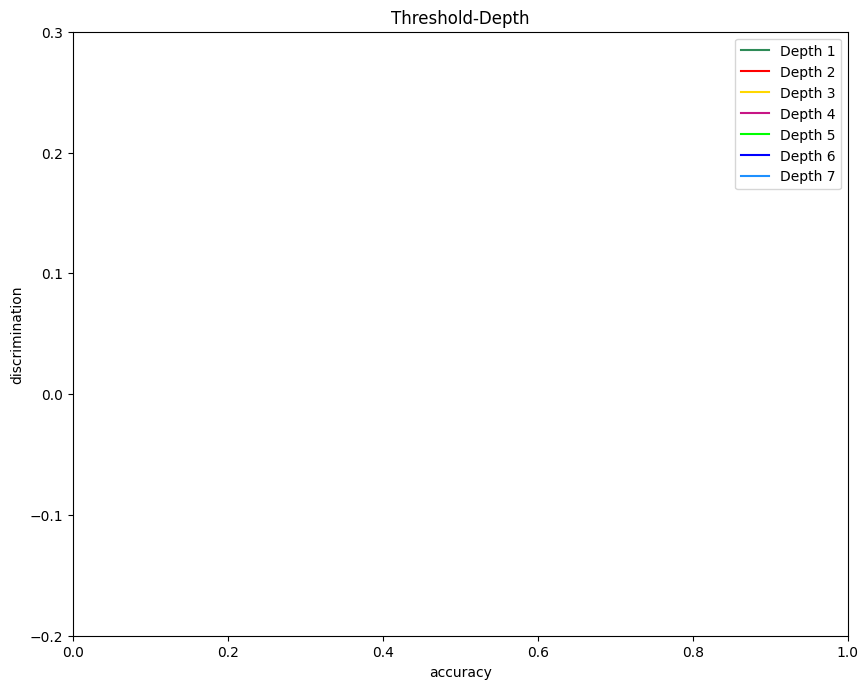

In [13]:
colors = _COLORS7.copy()
legends = ['Depth 1', 'Depth 2', 'Depth 3', 'Depth 4', 'Depth 5', 'Depth 6', 'Depth 7']
markers = ['o', 'x', 's', 'd', 'p', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

index_legend = 0
index_color = 0


fig, axes = plt.subplots()
k=1
for depth in result['depth'].unique():
    y_values = list()
    x_values = list()
    index_marker = 0
    for x_axe, y_axe in [('accuracy_relab_0.0', 'discrimination_relab_0.0'), ('accuracy_relab_0.1', 'discrimination_relab_0.1'), ('accuracy_relab_0.2', 'discrimination_relab_0.2'), ('accuracy_relab_0.3', 'discrimination_relab_0.3'), ('accuracy_pred', 'discrimination_train_pred')]:

        tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
        x_values.append(tmp[x_axe].mean())
        y_values.append(tmp[y_axe].mean())

        plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors[index_color], marker=markers[index_marker])
        index_marker +=1

    plt.plot(x_values, y_values, label=legends[index_legend], c=colors[index_color])
    index_color +=1
    index_legend +=1

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title(f'Threshold-Depth')
plt.ylabel('discrimination')
plt.xlabel('accuracy')
plt.ylim(-0.2, 0.3)
plt.xlim(0, 1)
plt.legend()

plt.show()

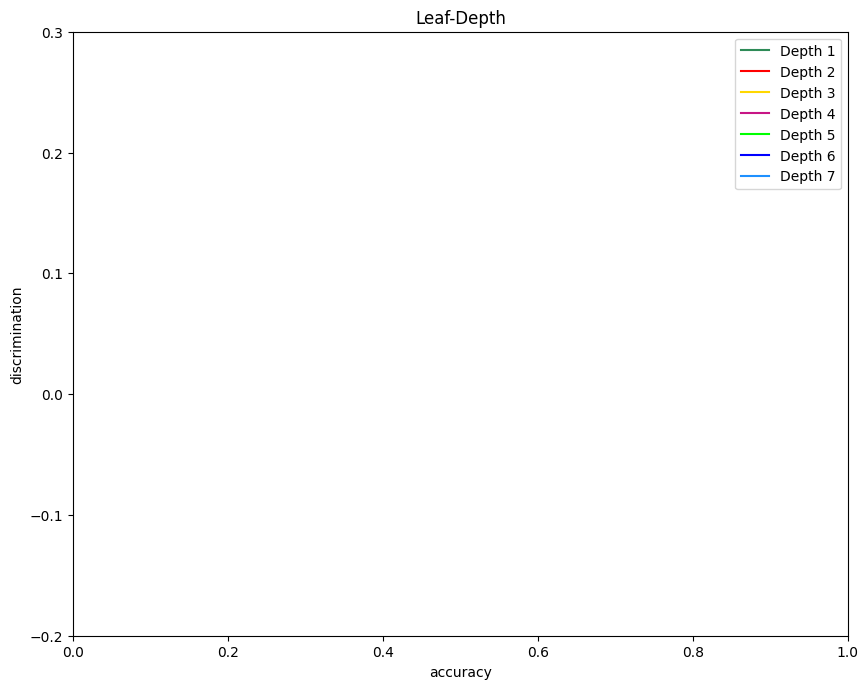

In [14]:
colors = _COLORS7.copy()
legends = ['Depth 1', 'Depth 2', 'Depth 3', 'Depth 4', 'Depth 5', 'Depth 6', 'Depth 7']
markers = ['o', 'x', 's', 'd', 'p', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

index_legend = 0
index_color = 0


fig, axes = plt.subplots()
k=1
for depth in result['depth'].unique():
    y_values = list()
    x_values = list()
    index_marker = 0
    for x_axe, y_axe in [('accuracy_pred', 'discrimination_train_pred'), ('accuracy_relab_1', 'discrimination_relab_1'), ('accuracy_relab_2', 'discrimination_relab_2'), ('accuracy_relab_3', 'discrimination_relab_3')]:

        tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
        x_values.append(tmp[x_axe].mean())
        y_values.append(tmp[y_axe].mean())

        plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors[index_color], marker=markers[index_marker])
        index_marker +=1

    plt.plot(x_values, y_values, label=legends[index_legend], c=colors[index_color])
    index_color +=1
    index_legend +=1

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title(f'Leaf-Depth')
plt.ylabel('discrimination')
plt.xlabel('accuracy')
plt.ylim(-0.2, 0.3)
plt.xlim(0, 1)
plt.legend()

plt.show()

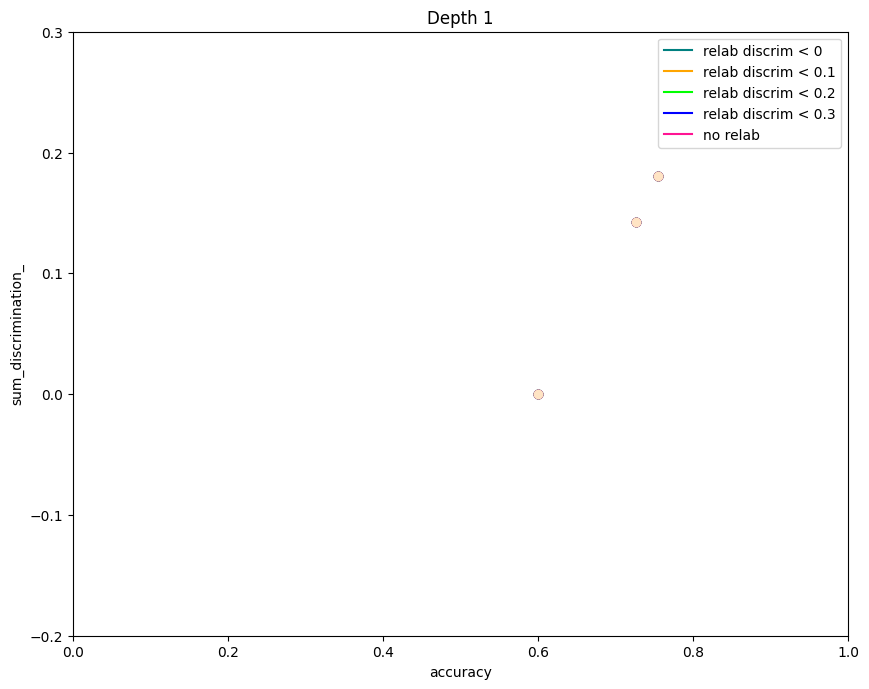

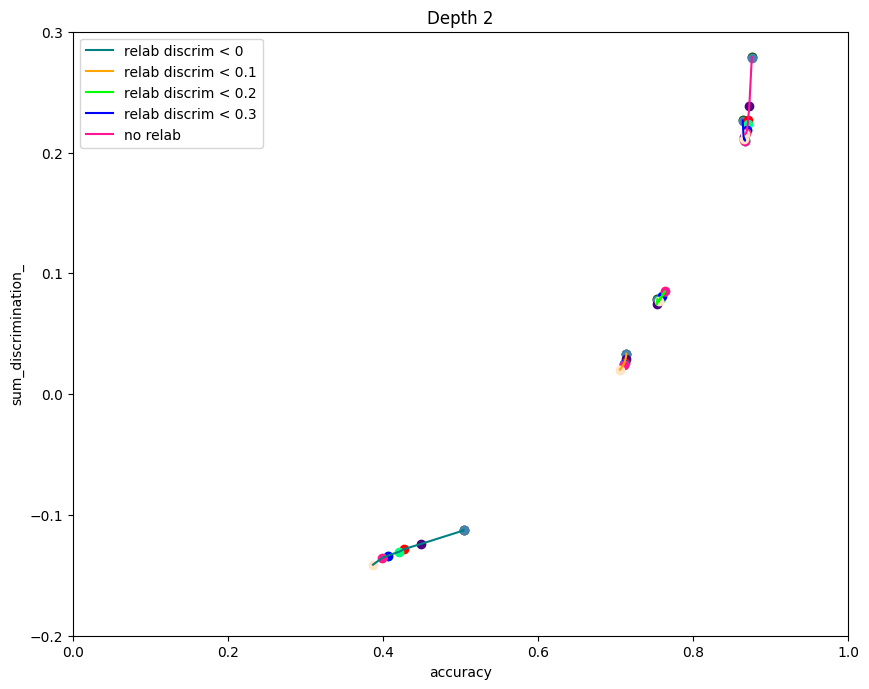

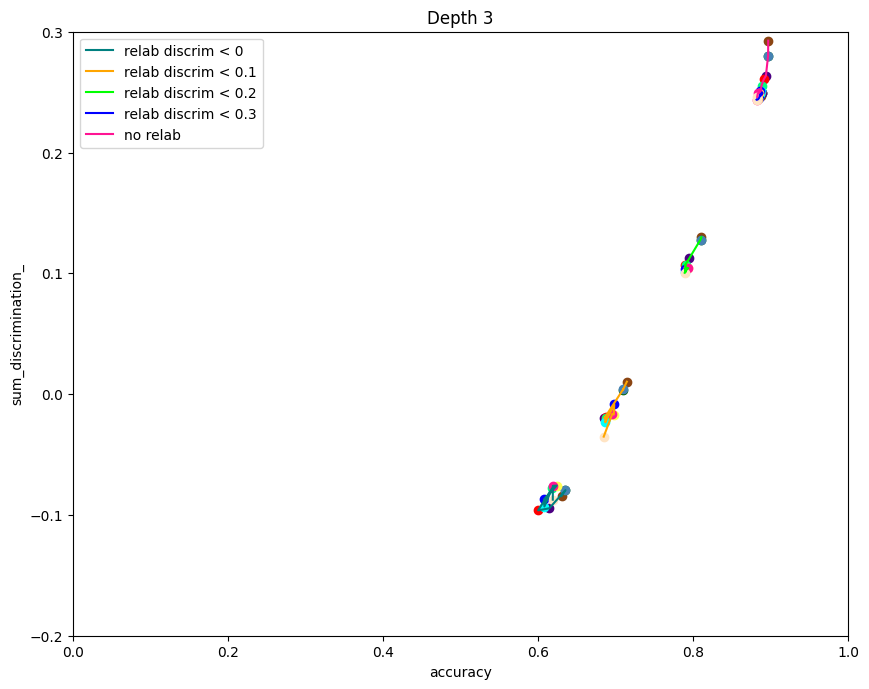

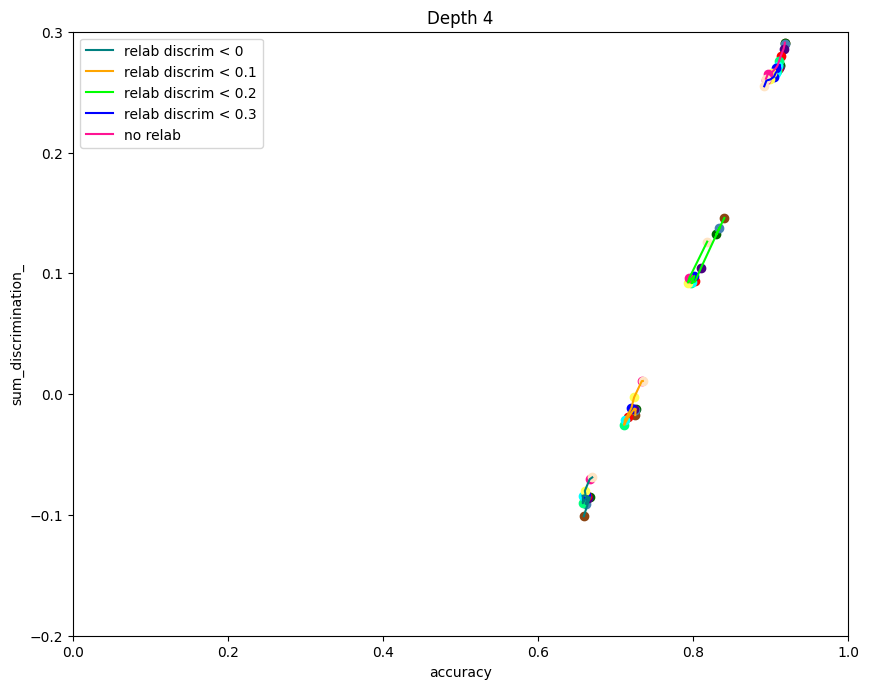

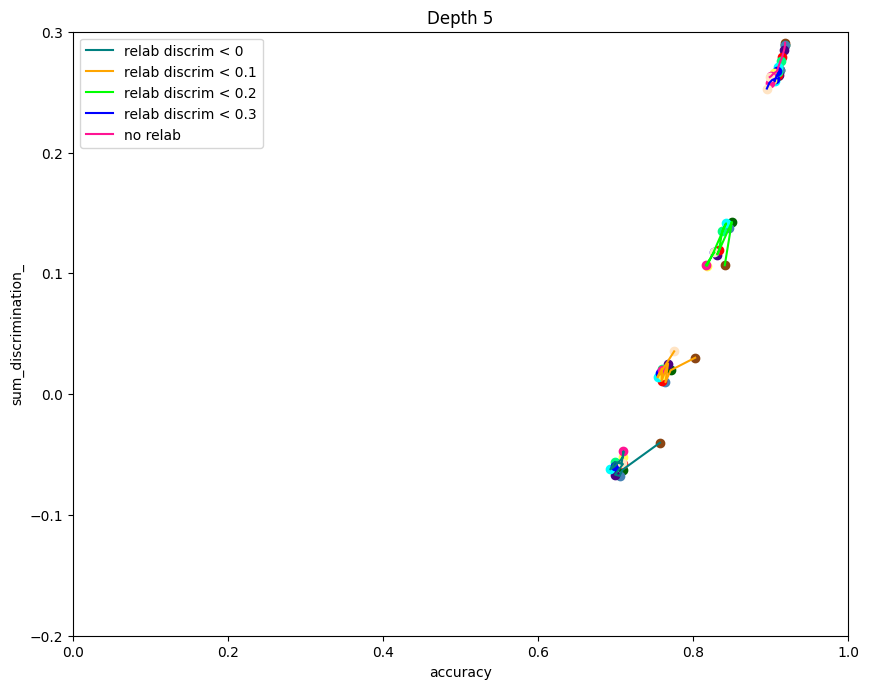

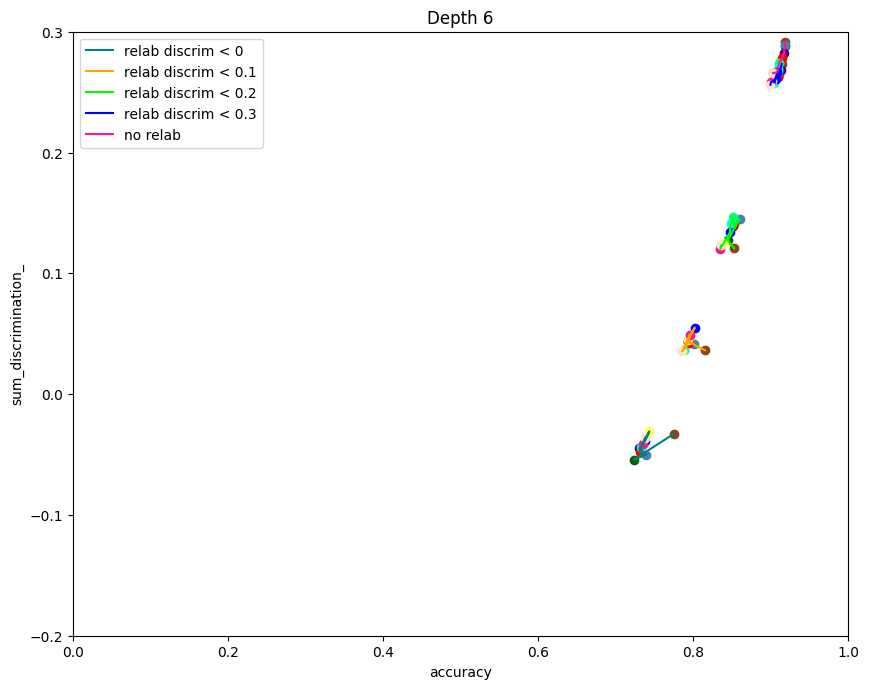

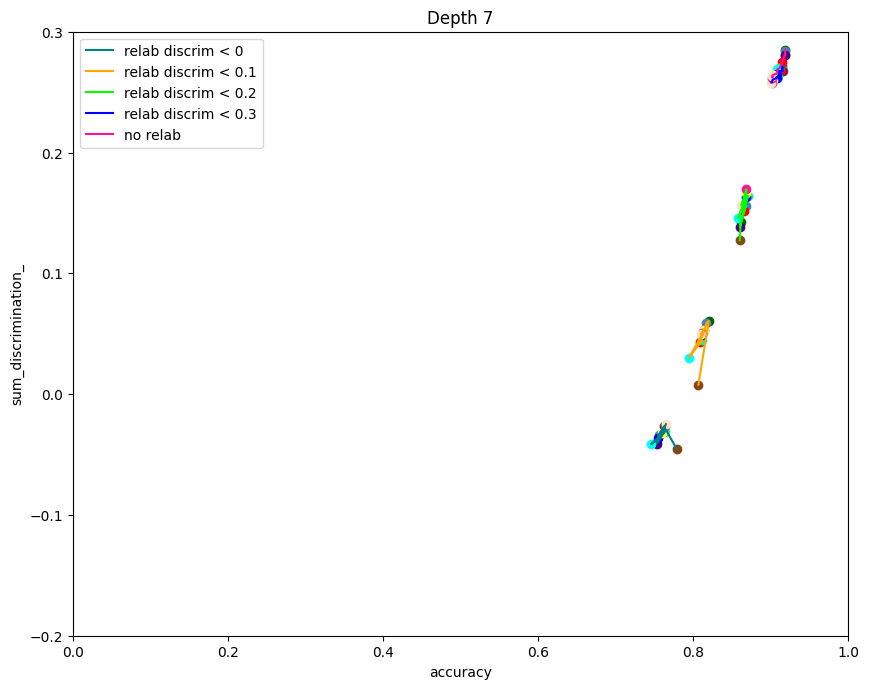

In [15]:
colors11 = _COLORS11.copy()
colors4 = _COLORS5.copy()
legends = ['relab discrim < 0', 'relab discrim < 0.1', 'relab discrim < 0.2', 'relab discrim < 0.3', 'no relab']
fig, axes = plt.subplots()
for depth in result['depth'].unique():
    index_legends = 0
    for x_axe, y_axe in [('accuracy_relab_0.0', 'discrimination_relab_0.0'), ('accuracy_relab_0.1', 'discrimination_relab_0.1'), ('accuracy_relab_0.2', 'discrimination_relab_0.2'), ('accuracy_relab_0.3', 'discrimination_relab_0.3'), ('accuracy_pred', 'sum_discrimination_additive_train_pred')]:
        index_color = 0
        y_values = list()
        x_values = list()
        for k in result['k'].unique():
            tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors11[index_color])
            """
            plt.annotate(k, # this is the text
                         (tmp[x_axe].mean(), tmp[y_axe].mean()), # these are the coordinates to position the label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
            """
            index_color +=1

        plt.plot(x_values, y_values, label=legends[index_legends], c=colors4[index_legends])
        index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('sum_discrimination_')
    plt.xlabel('accuracy')
    plt.ylim(-0.2, 0.3)
    plt.xlim(0, 1)
    plt.legend()

    plt.show()

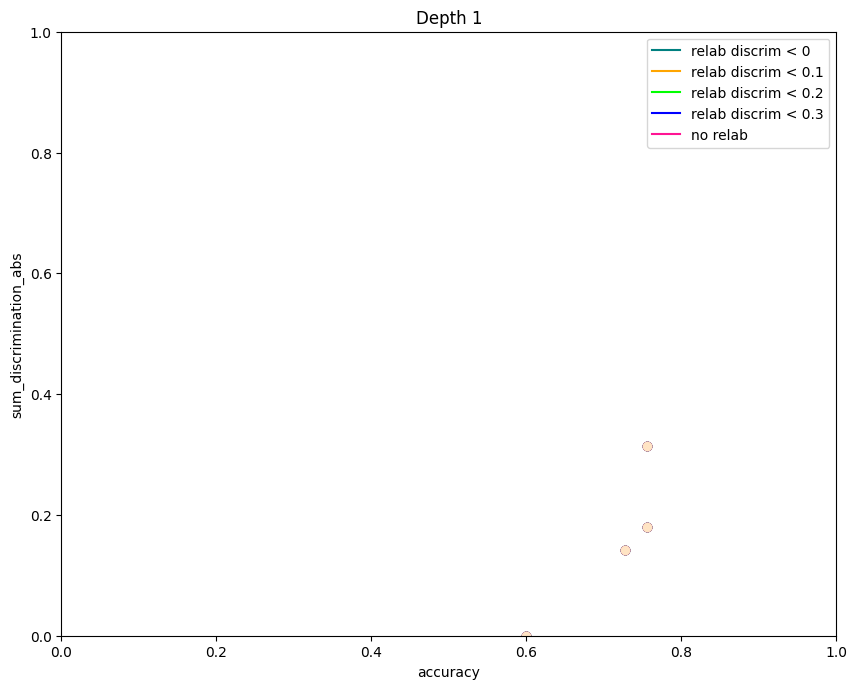

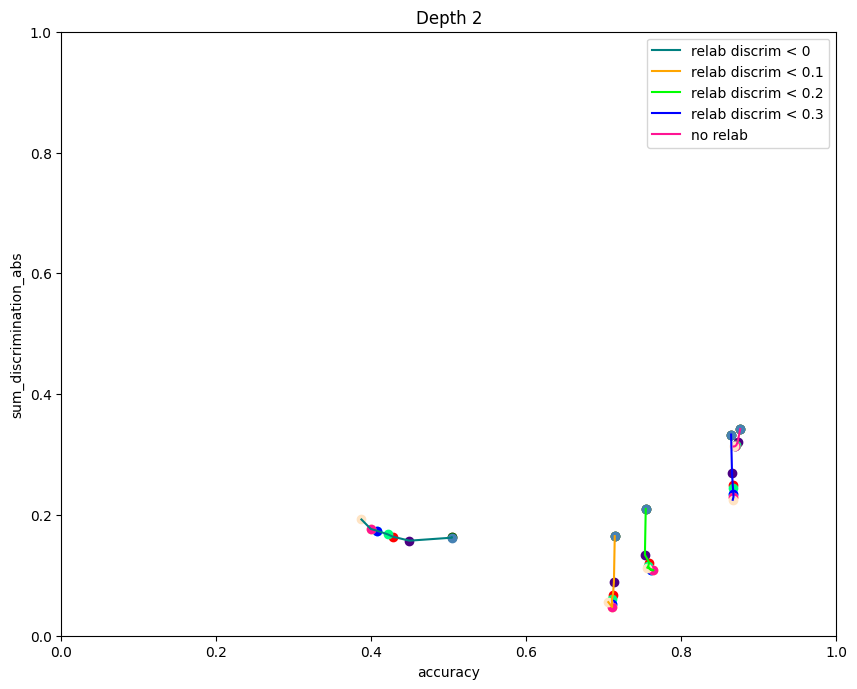

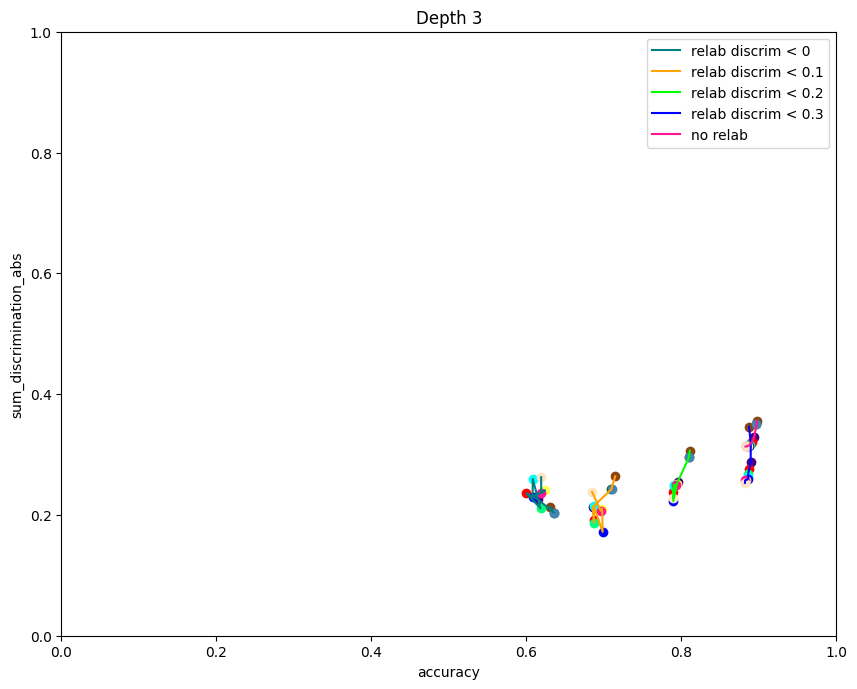

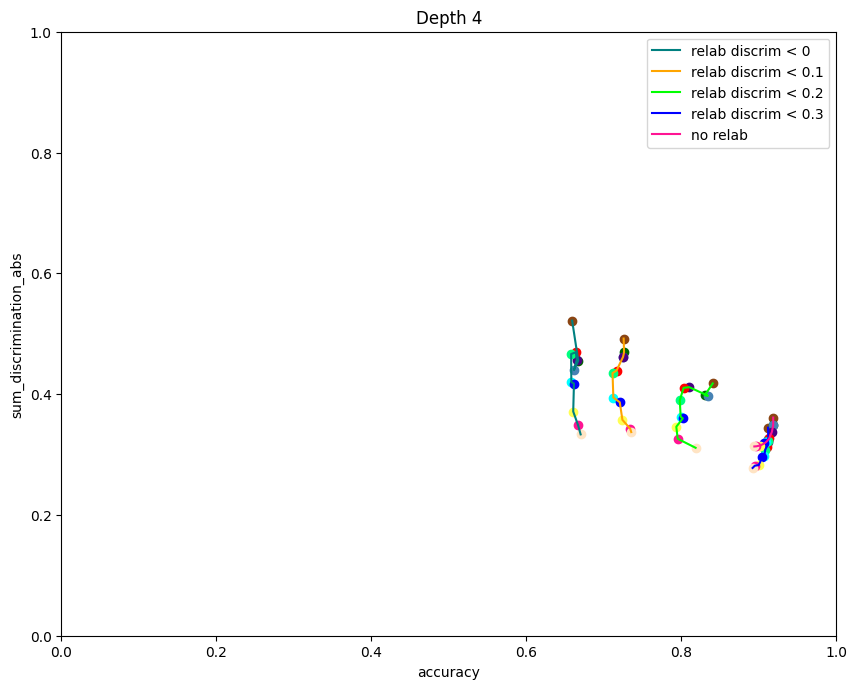

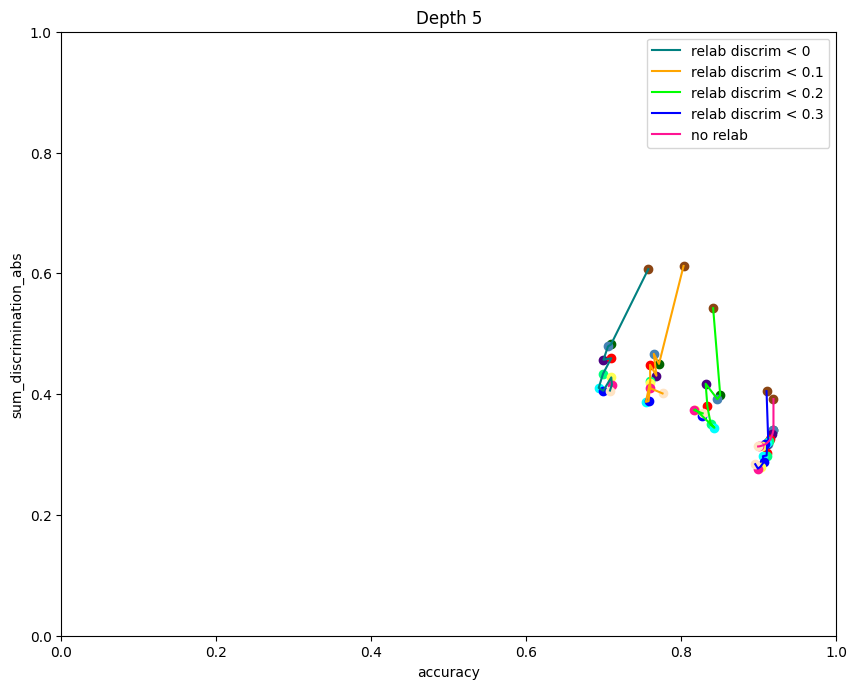

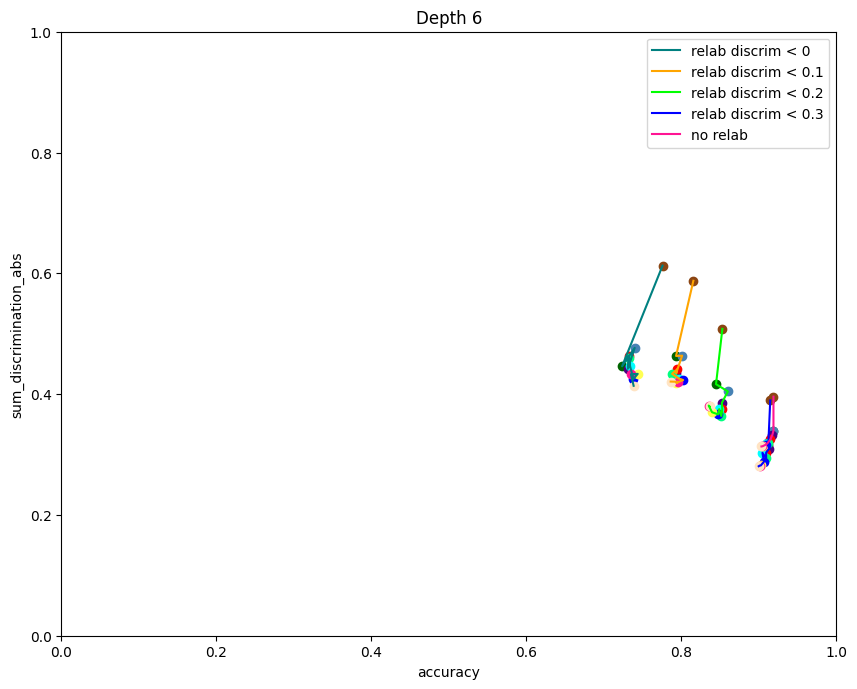

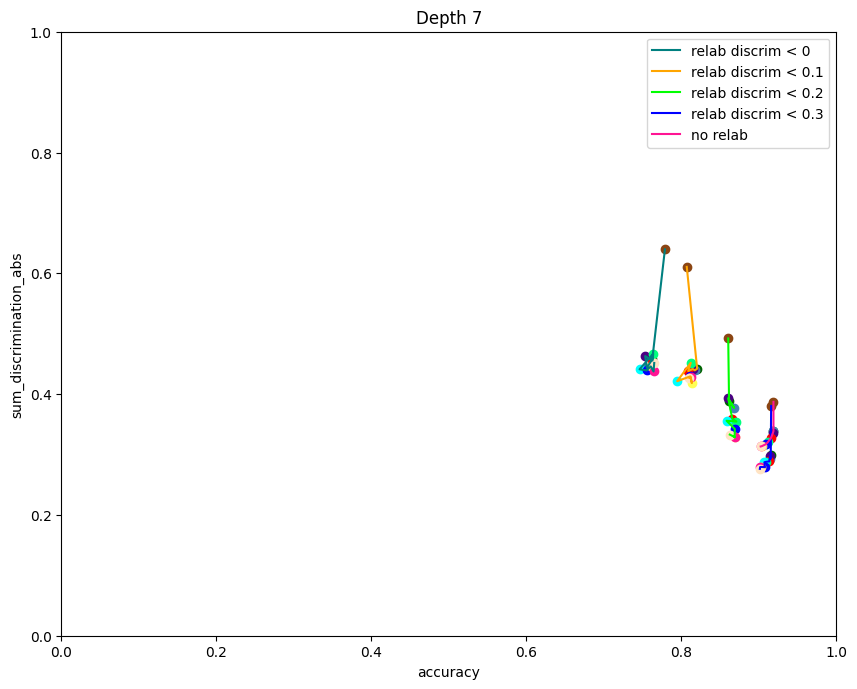

In [16]:
colors11 = _COLORS11.copy()
colors4 = _COLORS5.copy()
legends = ['relab discrim < 0', 'relab discrim < 0.1', 'relab discrim < 0.2', 'relab discrim < 0.3', 'no relab']
fig, axes = plt.subplots()
for depth in result['depth'].unique():
    index_legends = 0
    for x_axe, y_axe in [('accuracy_relab_0.0', 'discrimination_relab_abs_0.0'), ('accuracy_relab_0.1', 'discrimination_relab_abs_0.1'), ('accuracy_relab_0.2', 'discrimination_relab_abs_0.2'), ('accuracy_relab_0.3', 'discrimination_relab_abs_0.3'), ('accuracy_pred', 'sum_discrimination_additive_train_abs')]:
        index_color = 0
        y_values = list()
        x_values = list()
        for k in result['k'].unique():
            tmp = result.loc[(result["k"] == k) & (result["depth"] == depth)]
            x_values.append(tmp[x_axe].mean())
            y_values.append(tmp[y_axe].mean())

            plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors11[index_color])
            """
            plt.annotate(k, # this is the text
                         (tmp[x_axe].mean(), tmp[y_axe].mean()), # these are the coordinates to position the label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
            """
            index_color +=1

        plt.plot(x_values, y_values, label=legends[index_legends], c=colors4[index_legends])
        index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('sum_discrimination_abs')
    plt.xlabel('accuracy')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.legend()

    plt.show()

KeyError: 'sum_discri_0.0'

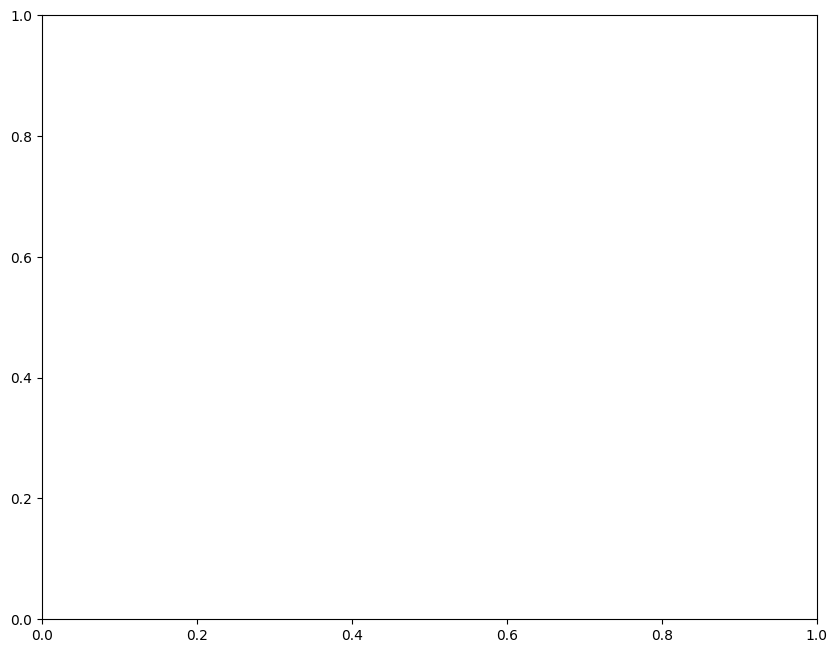

In [17]:
k=0

colors11 = _COLORS11.copy()
colors4 = _COLORS5.copy()
colors7 = _COLORS7.copy()
fig, axes = plt.subplots()
for depth in result['depth'].unique():
    index_legends = 0
   # for k in df['k'].unique():#df['k'].unique():
    #for k in [0, 10, 250, 5000, 100000]:#df['k'].unique():
    index_color = 0
    y_values = list()
    x_values = list()
    for x_axe, y_axe in [('sum_discri_0.0', 'sum_discri_abs_0.0'), ('sum_discri_0.1', 'sum_discri_abs_0.1'), ('sum_discri_0.2', 'sum_discri_abs_0.2'), ('sum_discri_0.3', 'sum_discri_abs_0.3'), ('sum_discrimination_additive_train_abs', 'sum_discrimination_additive_pred_abs')]:



        tmp = result.loc[(result["k"] == k) & (result["depth"] == depth) & (result["k"] == 0)]
        x_values.append(tmp[x_axe].mean())
        y_values.append(tmp[y_axe].mean())

        plt.scatter(tmp[x_axe].mean(), tmp[y_axe].mean(), c=colors4[index_color])
        index_color +=1



    plt.plot(x_values, y_values, label="k="+str(k), c=colors11[index_legends])
    index_legends +=1
    plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
    plt.title(f'Depth {depth}')
    plt.ylabel('sum_discrimination_abs')
    plt.xlabel('sum_discrimination')
    plt.ylim(-0.2, 1)
    plt.xlim(-0.2, 1)
    plt.legend()

    plt.show()